<a href="https://colab.research.google.com/github/DesiPilla/MLTSA_DPilla/blob/master/HW5/HW5_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## this homework will be split into 2. In the first part, due by Thursday 9th at noon, you will engineer features from time series. In the second half, due Wednesday 15th at midnight, you will use those features to find structure in the feature space (unsupervised learning, i.e. clustering) and classify by example with CART (supervised learning with random forest or gradient boosted tree models)

# Classifying astrophysical transients from photometry

## OVERVIEW

The PLAsTiCC challend is a Kaggle challange to classify astrophysical objects (e.g. stars, exploding stars, stars with planets transiting, black holes) based on their time variability in the light emission in 6 different bands. The sampling (the cadence of the observations) is designed to show what the upcming Rubin Observatory LSST (Legacy Survey of Space and Time) will see when it starts observing (in 2023). 

You can refer to this notebook https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit (written by my good riend Gautham Narayan in fact!) to get started and ingest and preprocess the PLASTiCC challenge data. However, this is written with a class (object oriented) and we have not talked about this syntax in class. If you are not familiar with classes do not worry about it (but you should learn them!). Also I do want you to extract the features yourself. So use it as a guideline, but do not just copy and paste.

Your task is to extract features, i.e. representations of the time series, and run 2 models on these feautes: a cluster model, and a classification tree. 



In [77]:
import pandas as pd
import numpy as np
import pylab as plt
from scipy import stats
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns
import json, os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
!pip install kaggle

# TASK:  Data Acquisition
 You can download the data from kaggle
 --- https://www.kaggle.com/c/PLAsTiCC-2018
 or from zenodo
 --- https://zenodo.org/record/2539456#.XonrIdNKjOQ
 Choose how to do it but make sure that it is a reproducible way (i.e. that Yuqic an grade each notebook and the data will be accessed automatically without modifications to the code). You will need the training data and the metadata files


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
cd '/content/drive/My Drive'

/content/drive/My Drive


In [0]:
!chmod 600 kaggle.json

In [0]:
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [13]:
mkdir 'Colab Notebooks/MLTSA/plastic'

mkdir: cannot create directory ‘Colab Notebooks/MLTSA/plastic’: File exists


In [14]:
cd 'Colab Notebooks/MLTSA/plastic'

/content/drive/My Drive/Colab Notebooks/MLTSA/plastic


In [0]:
# !kaggle competitions download PLAsTiCC-2018   # commented out because it already has been downloaded

In [0]:
# !unzip training_set.csv.zip                   # commented out because it has already been unzipped

In [17]:
#lcvs = pd.read_csv("data/plasticc_train_lightcurves.csv")
lcvs = pd.read_csv("training_set.csv")

# The Zenodo data include 1.4 million datapoints. 
## -- I am subsampling the data to develop the code 
# by using only the first 10000 datapoints (lcvs[:10000])

## -- When I am done I will run this on the larger dataset (commenting out #[:10000])
## note that I am choosing the first N=1000, as opposed to 1 every 100 or whatever 
## because there are 6 time series per obects in 6 filters (colors)

lcvs = lcvs#[:10000]
print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (1421705, 6)


In [18]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


read the Kaggle challenge for a description of the data . This "Starter Kit" which includes a notebook (written by y good friend Gautham Narayan) may be especially useful
https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit

For each object there are 6 time series in 6 different passbands (see overview.) 

In [19]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [20]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [21]:
metadata = pd.read_csv("training_set_metadata.csv")
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [22]:
metadata.columns

Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')

In [23]:
print("The metadata dataset contains more information for each time series: (time-series, columns)", metadata.shape)

The metadata dataset contains more information for each time series: (time-series, columns) (7848, 12)


* Deliverable: make sure you print statements like the ones above summarizing the size of the datasets you acquire and you show the beginning of each dataset



# TASK : data visualization - plot some time series 
You always need to visualize your data to get a sense of what we are working with
that for each object I have 6 bands: each object is plotted separately, all bands for each object are plotted together.

**Include object 84716**


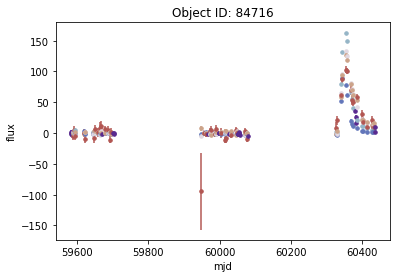

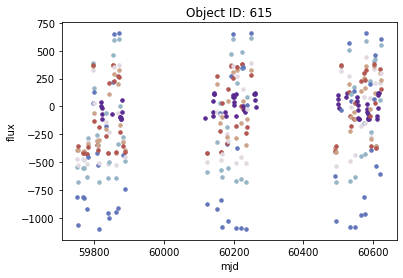

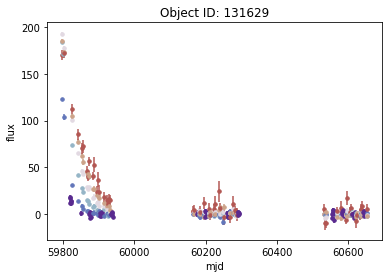

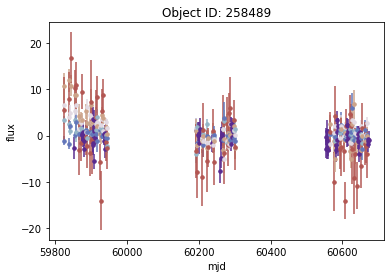

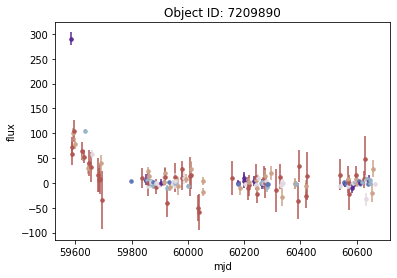

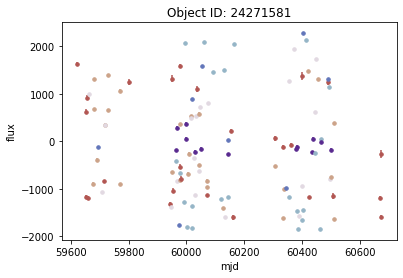

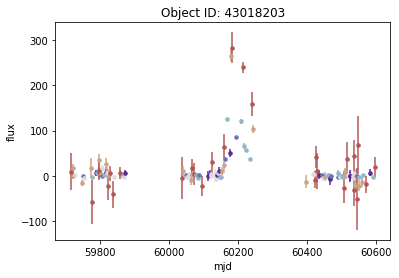

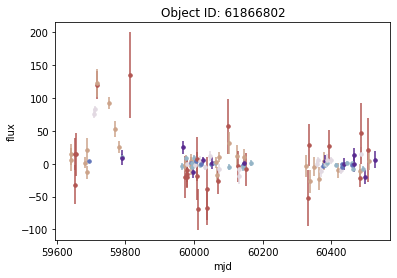

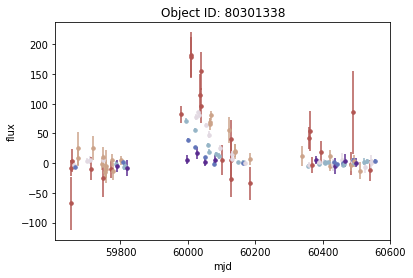

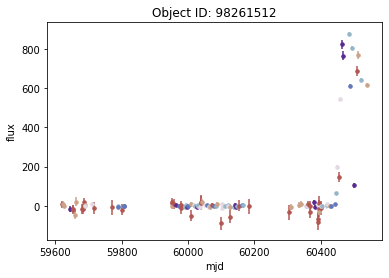

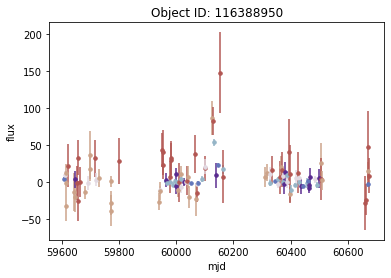

In [24]:
# preparing a normalization to pass to the color map to map red filters to red blue filters to blue
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

# -- plot one ever 100o objects
cmap = sns.color_palette("twilight_shifted", 7)

for i in [84716] + list(lcvs.object_id.unique()[::800]):
    fig, ax = plt.subplots()
    mjd = lcvs[lcvs.object_id == i]['mjd'].to_numpy()
    flux = lcvs[lcvs.object_id == i]['flux'].to_numpy()
    err = lcvs[lcvs.object_id == i]['flux_err'].to_numpy()
    c = [cmap[p] for p in lcvs[lcvs.object_id == i]['passband']]
    for j in range(len(mjd)):
        ax.errorbar(mjd[j], flux[j], yerr=err[j], fmt='.', c=c[j], markersize=7)
    ax.set_title('Object ID: {0}'.format(i))
    ax.set_ylabel('flux')
    ax.set_xlabel('mjd')
    fig.show();

**Figure 1:** The above figures plot the flux of the object against time. Each figure has errorbars relating to the uncertainty in the measurements. The plots show that the data is not evenly separated, and that there typically at least 3 distinct time periods during which the measurements are taken.

* Deliverable: make a plot for a subset of the objects (~10 at least). Describe what you are plotting and any notable things you see in the figure. Make sure you plot the time series (flux) against time (mjd) and also display the uncertainties int he measurement (fluxerr)

# TASK: Extract features
*You do not have to extract exaclyt the features I am extracting! These are just examples! Extract at least 6 features including 2 features from all three category below* 

The code that won the callenge did a number of smart things, of course. It was a feature based classification scheme, which included Gaussian Processes in the preprocessing. The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py

We will work similarly, extracting some basic features for each lightcurve. 

Note: we are working with bigg-ish data! 
First off: every new piece should be developed on a subset of the dataset, then run on all the data only when ready. 
Still, if you try achieve goals by implementing for loops you are not going to be able to run the notebook for the whole data, or even only 1 batch of the full datase. A good solution is to use the groupby() method in pandas. I used groupby everywhere. Also it may be wise to write out intermediate outputs, so you do not have to loose work if your kernel dies or something similar. 

My plan is to extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slop of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter


- **from the metadata file**:
    - decl ; important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    
The feature in the metadata files are the hardest ones to decide on because they require domain knowledge.
Most of the other features in the metadata are unknown for test objects (only known for the training set)

I am ok with you extracting different features! 

Extract **at least 6 features including 2 features from all three category above**: original lcv, standardized lcv, metadata. Justify each feature. Remember that if the features are extracted from the time series there will be 6 features for each choice of feature (for 6 passbands) so I end up with 94 features with the scheme outlined above

## TASK: 4.1
describe each feature you plan to extract. Briefly indicate why you think it is a valuable feature and what data type is it (e.g. continuous, binary, categorical, if continuous does it have a max or min value or is it unbound?)

* From the original lightcurve:
 * **Standard deviation:** This is an important feature because it tells how variable the time series is. This is an unbounded continuous variable.
 * **Kurtosis:** This is an important feature because it will tell how sharp the peaks are in the time series. This is an unbounded continuous variable.
* From the standardized lightcurve:
 * **Median:** This is an important feature because it gives a sense of the magnitude of the time series while excluding outliers in the data. This is an unbounded continuous variable.
 * **Log-Likelihood of a quadratic fit:** This is an important feature because it will tell how likely the time series is to be fitted with  a quadratic model. This is an unbounded continuous variable when using the statsmodels package OLS.
* From the metadata file:
 * **decl:** This feature is important because the position of the object on the sky may determine if it is galactic or extragalactic. This is an unbounded continuous variable
 * **ddf:** This feature is important because it tells what kind of data collection method was used. It is a Boolean variable (0 or 1).
        

## TASK 4.2 extract some features from the raw lightcurve

In [0]:
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std()

In [0]:
 def kurtosis(x):
    return stats.moment(x, moment=4)

kurt = lcvs.groupby(["object_id", "passband"])["flux"].apply(kurtosis)

In [28]:
features = stds.rename({"flux": "stds"}, 
                        axis=1).merge(kurt.rename({"flux": "kurt"}, 
                                axis=1), left_index=True, right_index=True)
features.rename(columns={'flux':'kurt'}, inplace=True)
features

stds          kurt
object_id passband                            
615       0            83.944735  7.433032e+07
          1           601.787302  2.215166e+11
          2           455.121346  6.659406e+10
          3           335.425053  1.919999e+10
          4           291.803449  1.036570e+10
...                          ...           ...
130779836 1          1197.557111  6.519913e+12
          2          6440.422386  2.746095e+16
          3          1443.868085  2.923373e+13
          4         11006.766106  2.715703e+17
          5          8687.101173  3.407459e+16

[47088 rows x 2 columns]

In [29]:
features.mean().to_list()

[205.58959779624107, 5.711718559065718e+19]

### Even with the same standard deviation two distribution can be very different. 
Look at the this article for a great demonstation of that! https://heap.io/blog/data-stories/anscombes-quartet-and-why-summary-statistics-dont-tell-the-whole-story

I extracted  the max and min, but also their uncertainties becaus outlier points may be measurement issues, in which case the uncertainty may be large : see the plot you made for 84716!

If a distribution has spikes the standard deviation will be larger even if the other datapoints are exactly the same. Save the mean and the max of both original distribution and the standardized one (standardized = mean subtracted and divided by the standard deviation). 


In [0]:
features_st = (features - features.mean()) / features.std()

maxs = [features.max().to_list(), features_st.max().to_list()]
mins = [features.min().to_list(), features_st.min().to_list()]

In [31]:
features_st

stds      kurt
object_id passband                    
615       0        -0.024283 -0.004623
          1         0.079091 -0.004623
          2         0.049813 -0.004623
          3         0.025918 -0.004623
          4         0.017210 -0.004623
...                      ...       ...
130779836 1         0.198021 -0.004623
          2         1.244623 -0.004621
          3         0.247190 -0.004623
          4         2.156175 -0.004601
          5         1.693114 -0.004620

[47088 rows x 2 columns]

## TASK 4.3 Standardize the lcvs and extract some features from the raw lightcurve - 
I have some examples of how I did it in the next few lines of code

In [0]:
lcvs["fluxnormed"] = 0.

In [0]:
# normalize each LC this is very slow.
def normed(df):
    df = df[['flux']]
    df = (df - df.mean()) / df.std() 
    return df
    
lcvs['fluxnormed'] = lcvs.groupby(["object_id", "passband"]).apply(normed)    

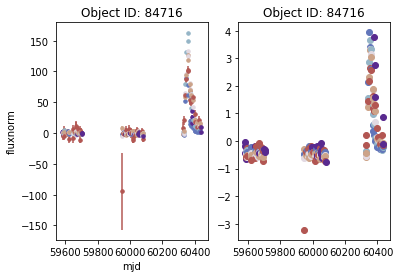

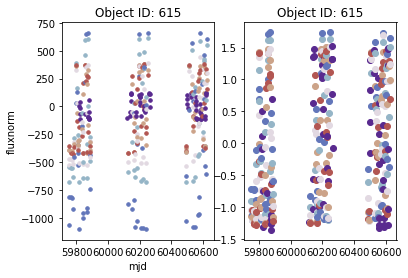

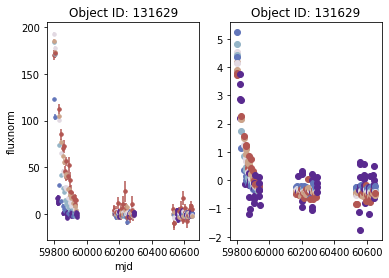

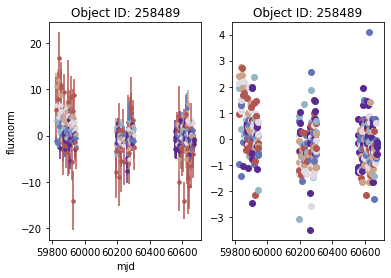

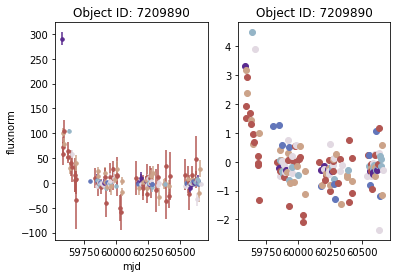

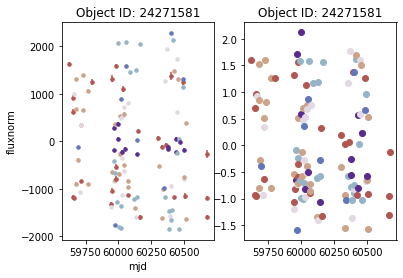

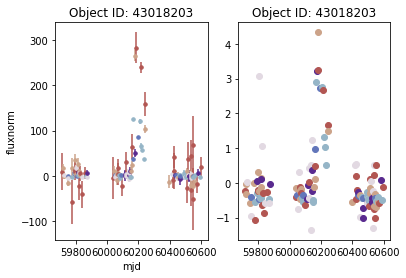

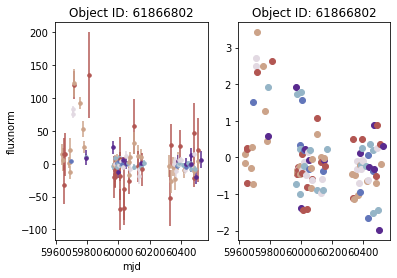

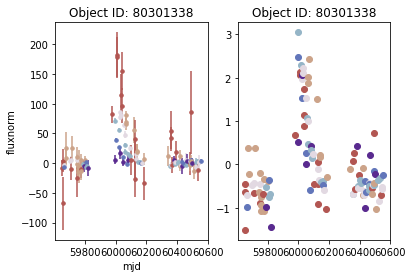

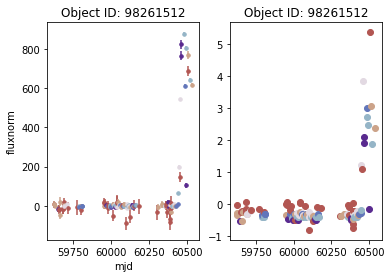

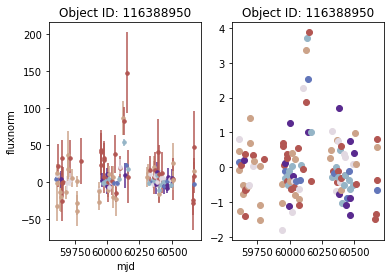

In [34]:
# preparing a normalization to pass to the color map to map red filters to red blue filters to blue
norm_band = Normalize(vmin=bands.min(), vmax=bands.max())

# -- plot one ever 100o objects
cmap = sns.color_palette("twilight_shifted", 7)

for i in [84716] + list(lcvs.object_id.unique()[::800]):
    fig, ax = plt.subplots(1, 2, sharex=True)
    mjd = lcvs[lcvs.object_id == i]['mjd'].to_numpy()
    flux = lcvs[lcvs.object_id == i]['flux'].to_numpy()
    fluxnorm = lcvs[lcvs.object_id == i]['fluxnormed'].to_numpy()
    err = lcvs[lcvs.object_id == i]['flux_err'].to_numpy()
    c = [cmap[p] for p in lcvs[lcvs.object_id == i]['passband']]
    for j in range(len(mjd)):
        ax[0].errorbar(mjd[j], flux[j], yerr=err[j], fmt='.', c=c[j], markersize=7)
        ax[1].scatter(mjd[j], fluxnorm[j], color=c[j])
    ax[0].set_title('Object ID: {0}'.format(i))
    ax[1].set_title('Object ID: {0}'.format(i))
    ax[0].set_ylabel('flux')
    ax[0].set_ylabel('fluxnorm')
    ax[0].set_xlabel('mjd')
    fig.show();

**Figure 2:** The above figures plot the flux of the object against time, and the normalized flux against time. The figures on the left have errorbars relating to the uncertainty in the measurements.

### min and max: if I did not get the means before I would store these data. since I have the mean and the min max of the un-standardized data this is irrelevant


In [0]:
maxs_standardized = lcvs.groupby(["object_id", "passband"])["fluxnormed"].max()
mins_standardized = lcvs.groupby(["object_id", "passband"])["fluxnormed"].min()

### the median of the standardized distribution will convey the location of the "center of mass" of the data with respect to the mean


In [36]:
medians = lcvs.groupby(["object_id", "passband"])[["fluxnormed"]].median()
medians

fluxnormed
object_id passband            
615       0          -0.080537
          1          -0.170090
          2          -0.289021
          3          -0.122434
          4          -0.163078
...                        ...
130779836 1          -0.513972
          2          -0.355787
          3          -0.406302
          4          -0.309318
          5          -0.416662

[47088 rows x 1 columns]

In [37]:
features = features.merge(medians.rename({"fluxnormed": "median"}, axis=1), left_index=True, right_index=True)
features

stds          kurt    median
object_id passband                                      
615       0            83.944735  7.433032e+07 -0.080537
          1           601.787302  2.215166e+11 -0.170090
          2           455.121346  6.659406e+10 -0.289021
          3           335.425053  1.919999e+10 -0.122434
          4           291.803449  1.036570e+10 -0.163078
...                          ...           ...       ...
130779836 1          1197.557111  6.519913e+12 -0.513972
          2          6440.422386  2.746095e+16 -0.355787
          3          1443.868085  2.923373e+13 -0.406302
          4         11006.766106  2.715703e+17 -0.309318
          5          8687.101173  3.407459e+16 -0.416662

[47088 rows x 3 columns]

## TASK 4.4: parametric features: extract some features that come from simple models of the lightcurve



### fit a line to the standardized data and store the slope and intercept as new features. See here for how to apply this with a groupby https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
If you can use groupby you get an extra point (cause that would be a very efficient way to do it)

In [0]:
def linfit(x):
    pars = np.polyfit(range(len(x)), x["fluxnormed"].values, 1)
    return pars
linfits = lcvs.groupby(["object_id", "passband"]).apply(linfit)

In [39]:
linfits.shape

(47088,)

In [0]:
slopes = [x[0] for x in linfits.values[:]]
intercepts = [x[1] for x in linfits.values[:]]

In [0]:
features["slopes"] = slopes
features["intercepts"] = intercepts

### A quadratic function can tell you if the time series is concave or convex. 
### If we fit both line and a quadratic we can also us the likelihood ratio to see wchich fit is best (remember the first couple of classes)

In [42]:
# this is slow!!
def quadfit(x):
    x['t'] = x.mjd - x.iloc[0].mjd
    m1 = ols(formula='fluxnormed~t + 1', data=x).fit()
    m2 = ols(formula='fluxnormed~pow(t, 2) + t + 1', data=x).fit()
    
    pars = m2.llf, m1.llf, np.sign(m2.params[1])
    return pars
    
ols = lcvs.groupby(["object_id", "passband"]).apply(quadfit)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:867: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


In [0]:
ll1 = [x[1] for x in ols.values[:]]
ll2 = [x[0] for x in ols.values[:]]
ll3 = [x[2] for x in ols.values[:]]
features["ll1"] = ll1
features["ll2"] = ll2
features["ll3"] = ll3

# Task 5: show your engineered feature space and add features from the metadata file

Note that in the way I cereated the feature dataframe I have a feature column for each object and bandpass. I need to manipulate the dataframe so that I have 6xN features per object where N is the number of eatures I engineered. 

In [44]:
features.head()

stds          kurt  ...        ll2  ll3
object_id passband                            ...                
615       0          83.944735  7.433032e+07  ... -84.013092 -1.0
          1         601.787302  2.215166e+11  ... -80.867915 -1.0
          2         455.121346  6.659406e+10  ... -80.092803 -1.0
          3         335.425053  1.919999e+10  ... -79.226482 -1.0
          4         291.803449  1.036570e+10  ... -78.160027 -1.0

[5 rows x 8 columns]

In [0]:
# unstack will do the trick ... 
allfeatures = features.drop(columns=['ll1', 'll3']).reset_index().set_index(['object_id','passband']).stack().unstack([1,2])

In [60]:
allfeatures.head()

passband           0                          ...         5                      
                stds          kurt    median  ...    slopes intercepts        ll2
object_id                                     ...                                
615        83.944735  7.433032e+07 -0.080537  ...  0.021319  -0.596932 -76.917754
713         7.113509  4.907398e+03 -0.052914  ... -0.037903   1.042343 -65.167686
730         1.828872  3.655013e+01  0.039463  ...  0.019612  -0.490299 -66.518080
745         4.374445  2.575248e+03 -0.169349  ... -0.002816   0.076043 -64.783463
1124        2.360084  1.101222e+02 -0.033864  ...  0.015555  -0.435534 -76.526495

[5 rows x 36 columns]

In [61]:
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [63]:
allfeatures = allfeatures.merge(metadata[['object_id', 'decl', 'ddf']], left_index=True, right_on='object_id').drop(columns='object_id')
allfeatures.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(0, stds)","(0, kurt)","(0, median)","(0, slopes)","(0, intercepts)","(0, ll2)","(1, stds)","(1, kurt)","(1, median)","(1, slopes)","(1, intercepts)","(1, ll2)","(2, stds)","(2, kurt)","(2, median)","(2, slopes)","(2, intercepts)","(2, ll2)","(3, stds)","(3, kurt)","(3, median)","(3, slopes)","(3, intercepts)","(3, ll2)","(4, stds)","(4, kurt)","(4, median)","(4, slopes)","(4, intercepts)","(4, ll2)","(5, stds)","(5, kurt)","(5, median)","(5, slopes)","(5, intercepts)","(5, ll2)",decl,ddf
0,83.944735,7.433032e+07,-0.080537,0.005676,-0.175947,-84.013092,601.787302,2.215166e+11,-0.170090,0.014032,-0.399902,-80.867915,455.121346,6.659406e+10,-0.289021,0.017676,-0.503760,-80.092803,335.425053,1.919999e+10,-0.122434,0.020475,-0.583524,-79.226482,291.803449,1.036570e+10,-0.163078,0.022343,-0.636786,-78.160027,294.779522,1.049535e+10,-0.129163,0.021319,-0.596932,-76.917754,-61.943836,1
1,7.113509,4.907398e+03,-0.052914,-0.041433,1.429423,-45.801483,5.712334,1.944373e+03,0.080189,-0.051648,1.420320,-36.052358,5.770738,1.935955e+03,0.117188,-0.053887,1.481892,-34.410798,6.450413,3.091660e+03,0.141552,-0.050983,1.402038,-38.701863,6.406989,2.938985e+03,0.016870,-0.050464,1.387765,-44.424807,7.094073,5.294322e+03,-0.094281,-0.037903,1.042343,-65.167686,-27.784405,1
2,1.828872,3.655013e+01,0.039463,-0.001798,0.063840,-101.249926,1.807229,3.870188e+01,0.016754,0.003167,-0.080770,-72.910038,5.559483,6.926529e+03,-0.343392,0.026905,-0.686084,-63.777334,8.191987,4.048490e+04,-0.314425,0.024491,-0.624531,-66.369632,10.710344,1.060595e+05,-0.308522,0.022552,-0.563811,-65.239486,13.332758,1.860606e+05,-0.149763,0.019612,-0.490299,-66.518080,-6.579593,1
3,4.374445,2.575248e+03,-0.169349,-0.013089,0.464675,-88.423048,25.964659,2.162844e+07,-0.185994,-0.003826,0.105205,-76.313623,31.957997,3.606109e+07,-0.290606,-0.003878,0.106641,-72.846380,34.967698,2.575691e+07,-0.373246,-0.003931,0.108112,-67.105516,33.069053,1.781661e+07,-0.358773,-0.004774,0.131296,-67.067827,26.060130,6.203072e+06,-0.306851,-0.002816,0.076043,-64.783463,-45.586655,1
4,2.360084,1.101222e+02,-0.033864,0.017117,-0.530614,-84.959510,8.107525,3.545471e+04,-0.429236,0.028666,-0.816982,-67.527468,21.319854,2.468546e+06,-0.438785,0.025384,-0.723449,-71.247906,26.270649,7.271993e+06,-0.383411,0.021342,-0.608237,-74.498916,26.865913,9.005039e+06,-0.303771,0.019736,-0.562470,-75.898716,21.434627,3.279413e+06,-0.229697,0.015555,-0.435534,-76.526495,-63.823658,1


* Deliverable: what is the shape of your final feature space?

In [57]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 39 features (columns)


# Task 6: Create your train and test set out of the feature matrix and preprocess them to remove correlation by scaling them along the feature axis
The goall is to have a fewature matrix, the endogenous variables, X, and the target vector, the y exogenous variable for each training and test set.
Scale your training and test sets to remove the correlation: each feature is preprocessed so that it is mean=0 and standard deviation =1 - we will talk about it in class but make sure you deliver in this notebook the scaled features as below.

### make sure you deal with missing data

In [65]:
# check for NaNs and infinities
print("there are {} NaN and {} infinity entries".format(
 (allfeatures.isna().sum().sum()), np.prod(allfeatures.shape) - (np.isfinite(allfeatures).sum().sum())))


there are 0 NaN and 0 infinity entries


In [66]:
np.isfinite(allfeatures).sum()

(0, stds)          7848
(0, kurt)          7848
(0, median)        7848
(0, slopes)        7848
(0, intercepts)    7848
(0, ll2)           7848
(1, stds)          7848
(1, kurt)          7848
(1, median)        7848
(1, slopes)        7848
(1, intercepts)    7848
(1, ll2)           7848
(2, stds)          7848
(2, kurt)          7848
(2, median)        7848
(2, slopes)        7848
(2, intercepts)    7848
(2, ll2)           7848
(3, stds)          7848
(3, kurt)          7848
(3, median)        7848
(3, slopes)        7848
(3, intercepts)    7848
(3, ll2)           7848
(4, stds)          7848
(4, kurt)          7848
(4, median)        7848
(4, slopes)        7848
(4, intercepts)    7848
(4, ll2)           7848
(5, stds)          7848
(5, kurt)          7848
(5, median)        7848
(5, slopes)        7848
(5, intercepts)    7848
(5, ll2)           7848
decl               7848
ddf                7848
dtype: int64

I the problem is with one of the likelihoods. 
I can drop that feature from the dataset or replace with something else. 



In [67]:
## dropping the observation
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna().shape


((7848, 38), (7848, 38))

In [68]:
## dropping the feature
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1).shape


((7848, 38), (7848, 38))

In [69]:
## filling with something else
allfeatures.shape, allfeatures.replace([np.inf, -np.inf], np.nan).fillna(-99).shape


((7848, 38), (7848, 38))

In [70]:
# -- personally I choose to drop the feature 
allfeatures = allfeatures.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
allfeatures

,"(0, stds)","(0, kurt)","(0, median)","(0, slopes)","(0, intercepts)","(0, ll2)","(1, stds)","(1, kurt)","(1, median)","(1, slopes)","(1, intercepts)","(1, ll2)","(2, stds)","(2, kurt)","(2, median)","(2, slopes)","(2, intercepts)","(2, ll2)","(3, stds)","(3, kurt)","(3, median)","(3, slopes)","(3, intercepts)","(3, ll2)","(4, stds)","(4, kurt)","(4, median)","(4, slopes)","(4, intercepts)","(4, ll2)","(5, stds)","(5, kurt)","(5, median)","(5, slopes)","(5, intercepts)","(5, ll2)",decl,ddf
0,83.944735,7.433032e+07,-0.080537,0.005676,-0.175947,-84.013092,601.787302,2.215166e+11,-0.170090,0.014032,-0.399902,-80.867915,455.121346,6.659406e+10,-0.289021,0.017676,-0.503760,-80.092803,335.425053,1.919999e+10,-0.122434,0.020475,-0.583524,-79.226482,291.803449,1.036570e+10,-0.163078,0.022343,-0.636786,-78.160027,294.779522,1.049535e+10,-0.129163,0.021319,-0.596932,-76.917754,-61.943836,1
1,7.113509,4.907398e+03,-0.052914,-0.041433,1.429423,-45.801483,5.712334,1.944373e+03,0.080189,-0.051648,1.420320,-36.052358,5.770738,1.935955e+03,0.117188,-0.053887,1.481892,-34.410798,6.450413,3.091660e+03,0.141552,-0.050983,1.402038,-38.701863,6.406989,2.938985e+03,0.016870,-0.050464,1.387765,-44.424807,7.094073,5.294322e+03,-0.094281,-0.037903,1.042343,-65.167686,-27.784405,1
2,1.828872,3.655013e+01,0.039463,-0.001798,0.063840,-101.249926,1.807229,3.870188e+01,0.016754,0.003167,-0.080770,-72.910038,5.559483,6.926529e+03,-0.343392,0.026905,-0.686084,-63.777334,8.191987,4.048490e+04,-0.314425,0.024491,-0.624531,-66.369632,10.710344,1.060595e+05,-0.308522,0.022552,-0.563811,-65.239486,13.332758,1.860606e+05,-0.149763,0.019612,-0.490299,-66.518080,-6.579593,1
3,4.374445,2.575248e+03,-0.169349,-0.013089,0.464675,-88.423048,25.964659,2.162844e+07,-0.185994,-0.003826,0.105205,-76.313623,31.957997,3.606109e+07,-0.290606,-0.003878,0.106641,-72.846380,34.967698,2.575691e+07,-0.373246,-0.003931,0.108112,-67.105516,33.069053,1.781661e+07,-0.358773,-0.004774,0.131296,-67.067827,26.060130,6.203072e+06,-0.306851,-0.002816,0.076043,-64.783463,-45.586655,1
4,2.360084,1.101222e+02,-0.033864,0.017117,-0.530614,-84.959510,8.107525,3.545471e+04,-0.429236,0.028666,-0.816982,-67.527468,21.319854,2.468546e+06,-0.438785,0.025384,-0.723449,-71.247906,26.270649,7.271993e+06,-0.383411,0.021342,-0.608237,-74.498916,26.865913,9.005039e+06,-0.303771,0.019736,-0.562470,-75.898716,21.434627,3.279413e+06,-0.229697,0.015555,-0.435534,-76.526495,-63.823658,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7843,15.998517,3.961876e+05,-0.045003,0.010847,-0.086780,-23.432623,42.103636,3.211401e+07,-0.282994,0.056925,-0.370012,-18.558453,9.781002,8.382947e+04,-0.281585,0.009331,-0.107307,-33.397434,9.132244,1.535764e+04,-0.245053,0.037509,-0.450103,-33.717240,16.735430,2.604266e+05,-0.029408,-0.015218,0.235874,-43.831962,97.602719,1.768533e+09,-0.091638,-0.021912,0.372506,-47.963730,-14.940303,0
7844,79.713932,3.126406e+08,-0.264846,-0.062990,0.346445,-15.325622,16.268582,4.645969e+05,-0.351126,-0.014109,0.070543,-13.870156,4.606559,9.217903e+02,0.066620,0.049441,-0.420251,-21.233756,88.177979,5.996601e+08,-0.258221,-0.004290,0.027885,-18.617332,108.319727,8.667740e+08,-0.331122,0.009737,-0.116845,-32.256807,38.849765,1.125906e+07,-0.108422,-0.003058,0.050458,-47.569288,-62.696659,0
7845,46.605187,2.694005e+07,0.164351,-0.057516,0.345093,-17.372063,23.572412,1.576221e+06,0.081505,0.109119,-0.872951,-20.286207,29.855715,1.570257e+06,-0.023363,-0.004481,0.051530,-32.714050,31.491707,2.929589e+06,0.076775,-0.128830,1.030637,-18.241627,22.364118,6.341943e+05,-0.107204,0.010708,-0.165973,-44.623068,48.309960,3.826628e+07,-0.026542,0.003563,-0.053441,-43.413986,-55.682144,0
7846,14.420201,1.343065e+05,-0.350661,0.019048,-0.123810,-19.054708,97.513710,6.791051e+08,-0.302563,0.121633,-0.608166,-14.032730,6.550608,1.796677e+04,-0.006650,0.022282,-0.267382,-33.485612,7.667434,1.289186e+04,

In [71]:
allfeatures.describe()

,"(0, stds)","(0, kurt)","(0, median)","(0, slopes)","(0, intercepts)","(0, ll2)","(1, stds)","(1, kurt)","(1, median)","(1, slopes)","(1, intercepts)","(1, ll2)","(2, stds)","(2, kurt)","(2, median)","(2, slopes)","(2, intercepts)","(2, ll2)","(3, stds)","(3, kurt)","(3, median)","(3, slopes)","(3, intercepts)","(3, ll2)","(4, stds)","(4, kurt)","(4, median)","(4, slopes)","(4, intercepts)","(4, ll2)","(5, stds)","(5, kurt)","(5, median)","(5, slopes)","(5, intercepts)","(5, ll2)",decl,ddf
count,7848.000000,7.848000e+03,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7.848000e+03,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7.848000e+03,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7.848000e+03,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7.848000e+03,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7.848000e+03,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000,7848.000000
mean,218.255899,3.416700e+20,-0.073098,0.000324,0.006375,-32.345330,188.291251,4.759577e+15,-0.158192,-0.004470,0.025887,-27.615405,204.791323,8.879453e+16,-0.201574,-0.002487,0.031919,-36.538777,198.862866,1.827638e+17,-0.194071,-0.001692,0.021126,-35.618223,204.063537,2.224106e+17,-0.169136,0.000694,-0.003418,-43.466798,219.272710,5.343603e+17,-0.118788,0.000335,-0.004259,-48.476629,-27.254846,0.269623
std,11315.691802,3.026436e+22,0.207628,0.090948,0.488814,31.603356,1163.874458,3.613837e+17,0.244825,0.109023,0.569417,25.842919,1912.299655,7.817988e+18,0.233385,0.052867,0.602343,19.346252,2252.966094,1.614480e+19,0.234898,0.054633,0.603403,19.461016,2144.890297,1.955705e+19,0.213332,0.037801,0.569038,16.079136,2801.422893,4.699183e+19,0.189432,0.032556,0.510647,15.868089,20.248556,0.443792
min,1.320344,2.810798e+00,-0.716695,-0.937096,-1.546036,-101.658661,1.067732,1.871336e+00,-0.799766,-0.992029,-1.578395,-81.792069,0.945899,2.855875e+00,-0.770700,-0.313588,-1.582615,-81.779142,1.510710,1.168250e+01,-0.779575,-0.259793,-1.581185,-81.790600,1.888631,3.250627e+01,-0.759410,-0.214812,-1.585839,-81.788705,3.822484,4.634848e+02,-0.718751,-0.316538,-1.584266,-80.371094,-64.760857,0.000000
25%,7.492090,7.670234e+03,-0.226345,-0.042110,-0.309765,-38.848112,3.454456,4.684675e+02,-0.331435,-0.059726,-0.384983,-51.682349,8.087892,2.720119e+04,-0.364184,-0.033111,-0.387352,-42.573717,11.667792,9.702241e+04,-0.359821,-0.036711,-0.415396,-42.576087,18.011516,4.522622e+05,-0.318616,-0.021696,-0.393181,-49.824632,29.121364,2.524583e+06,-0.247003,-0.016020,-0.318075,-59.589299,-44.597992,0.000000
50%,11.910417,5.354050e+04,-0.074179,-0.000382,0.006112,-17.206421,12.271235,1.335879e+05,-0.216989,-0.001573,0.020905,-14.638155,24.234703,2.732387e+06,-0.243169,-0.001895,0.033420,-29.597992,27.080255,3.694554e+06,-0.235463,-0.002089,0.032532,-28.508134,32.013689,6.705550e+06,-0.200578,0.000975,-0.016011,-40.075409,39.522688,9.060774e+06,-0.120399,0.000741,-0.014648,-47.845362,-27.279613,0.000000
75%,28.816596,2.517728e+06,0.067610,0.039350,0.332896,-13.993012,50.644401,3.515331e+07,0.000150,0.049177,0.439944,-11.817389,66.301702,1.431118e+08,-0.094772,0.029146,0.416677,-24.879373,67.925133,1.436120e+08,-0.071896,0.031445,0.434384,-23.674907,65.925929,1.175429e+08,-0.052333,0.024755,0.333537,-33.708360,64.926984,9.954585e+07,0.003016,0.018422,0.288631,-36.833261,-8.838267,1.000000
max,994447.659182,2.681088e+24,0.660805,1.414214,1.597381,102.947992,72095.882991,3.160613e+19,0.710041,0.737038,1.538115,101.154301,155637.297424,6.925840e+20,0.638279,0.295239,1.538992,30.441595,187435.285437,1.430249e+21,0.608942,0.314601,1.534260,33.722541,168644.941479,1.732527e+21,0.617443,0.223528,1.537957,69.916290,223784.002794,4.162922e+21,0.589131,0.272431,1.541157,51.179329,4.181528,1.000000


### split train-test set

In [0]:
X = allfeatures.iloc[:,:-1]
y = allfeatures.iloc[:,-1]

#remember to use the random state so that your work is reproducible and use a split between 60-40 and 75-25. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### scale train and test set

In [76]:
Xtrain_scaled = preprocessing.scale(X_train)
Xtest_scaled = preprocessing.scale(X_test)

print("scaled training data feature mean and standard deviations: ", 
      Xtrain_scaled.mean(axis=0), Xtrain_scaled.std(axis=0))

scaled training data feature mean and standard deviations:  [ 7.76125326e-18  3.88062663e-18 -1.00249521e-17 -5.17416884e-18
 -9.05479547e-18 -2.58708442e-17  2.91046997e-18  5.17416884e-18
 -7.76125326e-18 -8.56971714e-18 -1.22886510e-17 -1.03483377e-17
 -1.97265187e-17  6.46771105e-19 -1.55225065e-17  9.70156657e-18
  2.58708442e-18 -2.58708442e-18  7.76125326e-18  1.29354221e-18
  9.05479547e-18 -7.76125326e-18  4.52739773e-18 -1.03483377e-17
 -6.46771105e-18 -2.58708442e-18  2.71643864e-17 -1.09951088e-17
  4.20401218e-18 -1.29354221e-18  0.00000000e+00 -5.17416884e-18
 -1.68160487e-17  9.70156657e-18 -1.19652654e-17 -1.61692776e-17
  5.01247606e-18] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "



# Task 7: We will talk about what the next task means in class. read on to see how one can visualize a large dimensional feature space to plan the analysis and produce a 2D t-SNE projection of your feature space and visualize it. 
If you are lucky, this will be a pretty plot!
a great model to **Visualize** structure in data is  t-SNE: t-distributed Stocastic Neighbourhood Embedding
It project N-dimensional data on a 2-dimensional surface preserving the N-dimensional distance. If thre is structure in the feature space, it should show. If there is structure in feature space, clustering is a promising technique.


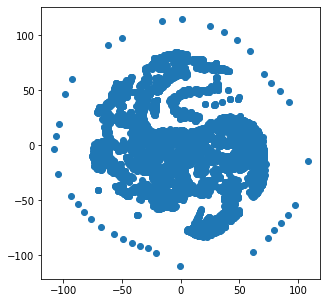

Figure: the 2D projection of the 79-dimensional feature space we created by extracting features from the time series. The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledianpairwise distances existing in the higher dimensional parameter space. How many clusters can you see in this embedding?A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, this is the only cxase in which you are allowed not to label your axes!


In [79]:
X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X)
X_embedded.shape
plt.figure(figsize=(5,5))
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()
print("Figure: the 2D projection of the 79-dimensional feature space we created by extracting features from the time series. " + 
      "The separation of the objects in the t-distribution based stocastic neighbourhood embedding (t-SNE) is promising: " + 
      "t-SNE is an embedding (a transformation to a different coordinate space) which is designed to preserve Eucledian" + 
      "pairwise distances existing in the higher dimensional parameter space. " + 
      "How many clusters can you see in this embedding?" + 
      "A note: since the t_SNE produces a projection of the feature space on an ideal set of coordinates, " + 
      "this is the only cxase in which you are allowed not to label your axes!")

We have to assure that the clusters map to the target variable tho. So I will redo the plot colorcoded by target variable

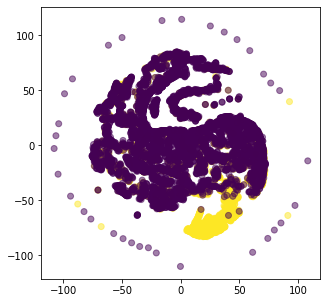

In [83]:
norm_obj= Normalize(vmin=y.min(), vmax=y.max())
len([c for c in plt.cm.RdBu_r(norm_obj(y.values))]), X_embedded.shape
plt.figure(figsize=(5,5))
plt.scatter(X_embedded[:,0], X_embedded[:,1],  
           color=[c for c in plt.cm.viridis(norm_obj(y.values))], alpha=0.5);

**Figure 3:** The purity of the sample is good in the t-SNE projection against the target variable.

Does this map better on other features in the metadata?

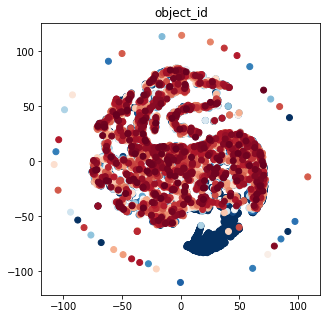

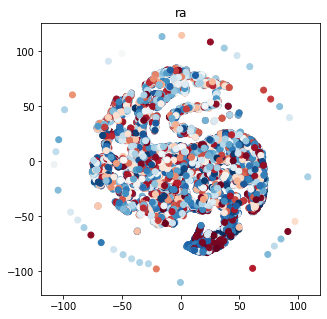

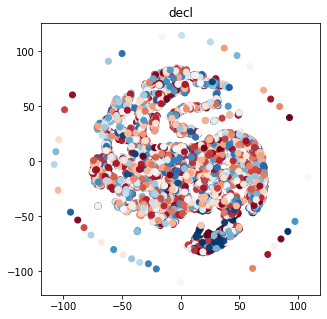

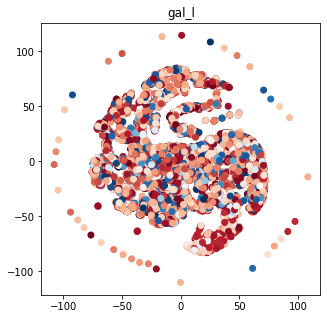

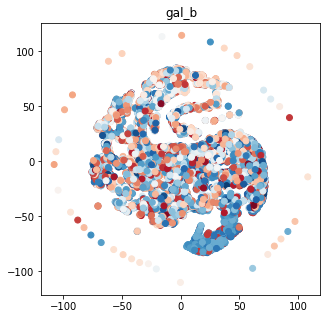

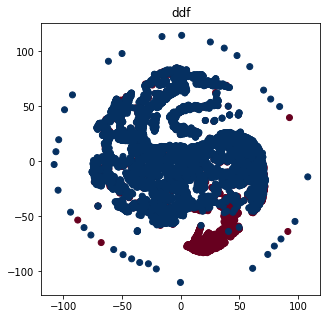

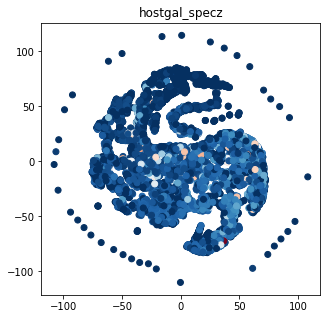

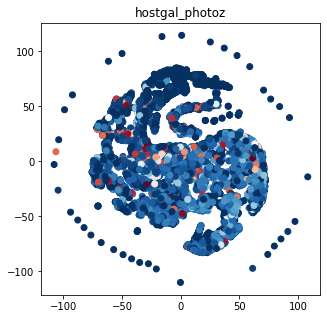

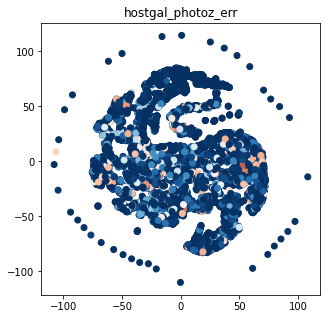

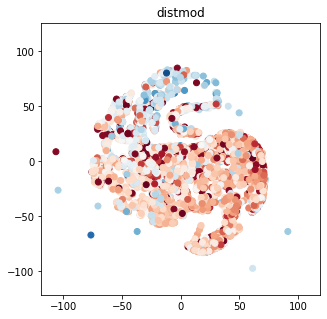

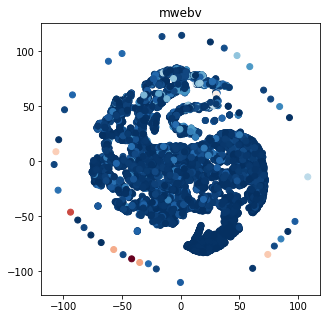

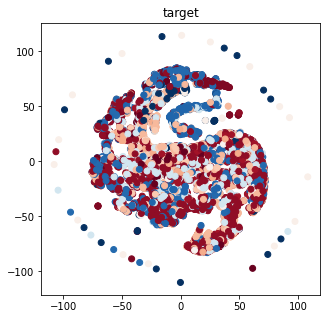

In [85]:
for col in metadata.columns:
    v = metadata[col].astype(float)
    plt.figure(figsize=(5,5))
    plt.title(col)
    plt.scatter(X_embedded[:,0], X_embedded[:,1],  color=[plt.cm.RdBu_r(Normalize(vmin=v.min(), vmax=v.max())(c))
                                                         for c in v])

    plt.show()

**Figure 4:** Two dimensional plots of each feature space against the target variable.